In [3]:
import pandas as pd #import pandas
import numpy as np #import numpy
import math #import math
import os #import os
from datetime import datetime #import datetime
import matplotlib.pyplot as plt
import matplotlib.dates

In [4]:
#this function is from stack exchange: 
#https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def hasNumbers(inputString): #defines a function testing whether a string has numbers in it
    return any(char.isdigit() for char in inputString) 

In [5]:
cwd = os.getcwd()  # Name the current working directory cwd
files = os.listdir(cwd) #Makes and names a list of the files in the working directory

In [6]:
#this chunk creates a dictionary of each data-containing sheet in the directory
#with keys of the sheet name and values of the sheet as a dataframe
#namesheets creates a list of the names of each sheet.

nameSheets = list() #initializes a list of the names of each sheet
dict_of_dfs = dict()

for filename in files: #iterating over the list of files
    if filename.endswith(".xls"): #it seems that .xls and .xlsx need to be treated differently. 
                                  #Directory contains both
        name = pd.ExcelFile(filename) #names the file
        
        for sheet in name.sheet_names: #iterates through each sheet in the file. There is a different and
                                        #unpredictable number of sheets in each file.
            if hasNumbers(sheet) == True and 'RADIO' not in sheet and "Sheet" not in sheet: 
                        #if the sheet has a number in it and does not include the strings "RADIO" or "Sheet",
                        #append sheet name to nameSheets
                nameSheets.append(sheet) #add the sheet to the list of names of sheets
                df = pd.read_excel(name, sheet, header = None) #read the sheet and produce a dataframe df,
                                                               #without a header row
                dict_of_dfs[sheet] = df # storing these as a dict was an idea my friend Gabe suggested,
                                        #because I couldn't figure out how to name them all
                    
#makes a list of lists containing the revised first row (headers) of all the sheets and turns it into a dataframe

headerList = list()
subheaderList = list()
for key in dict_of_dfs: #iterates through each sheet
    headers = dict_of_dfs[key].iloc[0] # saves the Series from column 0 as headers
    headerList.append(headers) #appends to headerList
    subheaders = dict_of_dfs[key].iloc[1] # saves the Series from row 1 as subheaders
    subheaderList.append(subheaders) #appends to headerList
headerCheck = pd.DataFrame(headerList) #makes a dataframe headerCheck from headerList (list of lists)
subheaderCheck = pd.DataFrame(subheaderList) #makes a dataframe subheaderCheck from headerList (list of lists)
col0names = headerCheck[0].unique()
col1names = headerCheck[1].unique()
col2names = headerCheck[2].unique()

In [7]:
col0names

array([nan, ' ', '  ', 'Date', 'Collect    '], dtype=object)

In [8]:
col1names

array([nan, ' ', 'Location', 'Sampling', 'Time ', 'Time'], dtype=object)

In [9]:
col2names

array(['1 BOD', 'BOD', 'DO  ', 'Sampling', 'Time '], dtype=object)

In [10]:
pd.set_option("display.max_rows", 216, "display.max_columns", 131) 
#headerCheck

In [11]:
pd.set_option("display.max_rows", 216, "display.max_columns", 131) 
#subheaderCheck

In [12]:
#puts column labels in the same row, reduces multiple names in column 0, 1, and 2 to just Station or Date or Time

for key in dict_of_dfs:
    if type(dict_of_dfs[key].iloc[0,0]) == float:    
        if math.isnan(dict_of_dfs[key].iloc[0,0]):
            dict_of_dfs[key].iloc[0,0] = dict_of_dfs[key].iloc[1,0]
    if dict_of_dfs[key].iloc[0,0] == ' ' or dict_of_dfs[key].iloc[0,0] == '  ':
        dict_of_dfs[key].iloc[0,0] = dict_of_dfs[key].iloc[1,0]
    if dict_of_dfs[key].iloc[0,0] == 'Collect    ':
        dict_of_dfs[key].iloc[0,0] = 'Date'
        
#repeats above, for column 1 (station or time) and column 2 (station, when column 1 is time)
for key in dict_of_dfs: #iterate through each sheet
    if type(dict_of_dfs[key].iloc[0,1]) == float: #all NaNs are floats so this looks for floats
        if math.isnan(dict_of_dfs[key].iloc[0,1]): #checks for NaN
            dict_of_dfs[key].iloc[0,1] = dict_of_dfs[key].iloc[1,1] #copies value below over NaN
    if dict_of_dfs[key].iloc[0,1] == ' ' or dict_of_dfs[key].iloc[0,1] == '  ': #checks for particular blanks, 
                                                                                #identified in col1names
        dict_of_dfs[key].iloc[0,1] = dict_of_dfs[key].iloc[1,1] #copies value below over blank
    if dict_of_dfs[key].iloc[0,1] == 'Sampling' or dict_of_dfs[key].iloc[0,1] == 'Location': #checks for alt labels
        dict_of_dfs[key].iloc[0,1] = 'Station' #replaces with standard label
    if dict_of_dfs[key].iloc[0,1] == 'Time ': #checks for alternate label
        dict_of_dfs[key].iloc[0,1] = 'Time' #replaces with standard label
    if dict_of_dfs[key].iloc[0,2] == 'Sampling': #checks for alternate label
        dict_of_dfs[key].iloc[0,2] = 'Station' #replaces with standard label

In [13]:
#standardizes the names of any column storing chloride data and
#distinguishes between numerical data and quality control notes

#by examination of headercheck (above), I determined that chloride data is stored in columns titled 
#'10 Cl- ', 'Cl', 'Chloride', 'CL', and 'CLx' where x is various numbers of spaces.

#similarly, I determined by examination of subheadercheck that quality control notes were in columns
#indicated by various capitalizations of 'qual code', and that all capitalizations' had 'ode' in common.

headerClList = list()
clSubheadCheck = list()
clHeadCheck = list()
l = list()
m = list()
for key in dict_of_dfs:
    headersCl = dict_of_dfs[key].iloc[0] # saves the Series from col 0 as headers               

    for i in range(len(headersCl)):
        if dict_of_dfs[key].iloc[0,i] == '10 Cl-'\
        or dict_of_dfs[key].iloc[0,i] == 'Cl'\
        or 'CL' in str(dict_of_dfs[key].iloc[0,i])\
        or dict_of_dfs[key].iloc[0,i] == 'Chloride': 
            dict_of_dfs[key].iloc[0,i] = 'Chloride'
            if 'ode' in str(dict_of_dfs[key].iloc[1,i]):           
                dict_of_dfs[key].iloc[0,i] = 'Chloride Qual Code'  
            clSubhead = (dict_of_dfs[key].iloc[1,i])               
            clHead = (dict_of_dfs[key].iloc[0,i])                  
            clSubheadCheck.append(clSubhead)                        
            clHeadCheck.append(clHead)

#Now that the header rows have been sorted out, make them headers again:
for key in dict_of_dfs: #iterate through sheets
    dict_of_dfs[key].columns = dict_of_dfs[key].iloc[0] #assign first row as column headers

In [14]:
#Find the sheets with date formatted as something other than Timestamp or datetime
typelist=list() #makes an empty list, typelist
for key in dict_of_dfs: #iterates through sheets
    x = list() #makes a list x
    x.append(key) #adds the current key to x
    x.append(type(dict_of_dfs[key].iloc[3,0])) #adds the type of this sheet's location 3,0 to list x
    typelist.append(tuple(x)) #turns list x into a tuple and adds the tuple to typelist
typelist

[('WW1970', pandas._libs.tslibs.timestamps.Timestamp),
 ('WW1972', pandas._libs.tslibs.timestamps.Timestamp),
 ('WW1973', pandas._libs.tslibs.timestamps.Timestamp),
 ('WW1974', pandas._libs.tslibs.timestamps.Timestamp),
 ('WW1975', str),
 ('1976', str),
 ('1977', str),
 ('WW78BR', str),
 ('WW79BR', str),
 ('WW80BR', str),
 ('1981', pandas._libs.tslibs.timestamps.Timestamp),
 ('1982', pandas._libs.tslibs.timestamps.Timestamp),
 ('1983', pandas._libs.tslibs.timestamps.Timestamp),
 ('1984', pandas._libs.tslibs.timestamps.Timestamp),
 ('1985', pandas._libs.tslibs.timestamps.Timestamp),
 ('1986', pandas._libs.tslibs.timestamps.Timestamp),
 ('1987', pandas._libs.tslibs.timestamps.Timestamp),
 ('1988', pandas._libs.tslibs.timestamps.Timestamp),
 ('1989', pandas._libs.tslibs.timestamps.Timestamp),
 ('1990', pandas._libs.tslibs.timestamps.Timestamp),
 ('1991', pandas._libs.tslibs.timestamps.Timestamp),
 ('1992', pandas._libs.tslibs.timestamps.Timestamp),
 ('1993', pandas._libs.tslibs.timestamps

In [15]:
#some dates have a month but no day recorded, and this section handles that too.
def fixDateString(sheet):
    for index, s in enumerate(dict_of_dfs[sheet].iloc[:,0]): #Gabe taught me this structure
        if type(s) == str and s[3:5] == ' 0':    #checks for a date as string with a month but no day
            s = s[0:3]+s[6:]                     #excises bad date
            if s[0:1] == ' ':                    #checks whether month is written badly
                s = '0' + s[1:]                  #if so, adds 0
            s = datetime.strptime(s, '%m/%y')    #converts to date time in month/year format
        elif type(s) == str and len(s)>5 and s[0:1] == ' ': #if type is string, length greater than month-day, 
                                                            #and badly formatted month
            s = '0' + s[1:]                      #fixes month formatting
            s = datetime.strptime(s, '%m/%d/%y') #converts to date time
        elif type(s) == str and len(s)>5:        #if type is string, length greater than month-day, 
                                                 #and month not formatted badly
            s = datetime.strptime(s, '%m/%d/%y') #converts to date time
        else:                                    #before I added this, the columns were 
                                                 #not maintaining correct row alignment
            s = s                                #it's a mystery
        dict_of_dfs[sheet].iloc[:,0][index] = s  #whatever happened in the last 4 statements, 
                                                 #assign the new value to replace the old s.

In [16]:
#repeat for all sheets with dates as strings. 
fixDateString('WW1975')
fixDateString('1976')
fixDateString('1977')
fixDateString('WW78BR')
fixDateString('WW79BR')
fixDateString('WW80BR')

In [17]:
#this section extracts the date, station, and chloride columns for each sheet and appends them to a single df.
#Then, it drops any row with a NaN in the row, any duplicate row, any row in which the value in the 
#'Station' column is 'Station' (as opposed to a station number), and re-indexes the new dataframe.

singledf = pd.DataFrame()
for key in dict_of_dfs:
    newdf = pd.DataFrame(dict_of_dfs[key][['Date', 'Station', 'Chloride']])
    singledf = pd.concat([singledf,newdf])

singledf = singledf.dropna()
singledf = singledf.drop_duplicates()
singledf = singledf.loc[singledf['Station'] != 'Station', ['Date','Station', 'Chloride']]
singledf = singledf.reset_index()
stationValues = singledf.Station.unique()

In [18]:
stationValues

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 32, 31, 33, 34, 35, 40, 41, 44, 45, 46, 47, 42, 43, 36, 37,
       38, 39, 61, 49, 55, 50, 51, 52, 53, 54, 56, 57, 58, 60, 59, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 77, 78, 79, 80, 8.4, 48, 73, 74,
       75, 76, 85, 90, 89, 82, 86, 'point ', 'WW_50', 'WW_86', 'WW_54',
       'WW_76', 'WW_58', 'WW_59', 'WW_43', 'WW_34', 'WW_36', 'WW_37',
       'WW_73', 'WW_46', 'WW_74', 'WW_39', 'WW_40', 'WW_75', 'WW_41',
       'WW_42', 'WW_48', 'WW_89', 'WW_80', 'WW_18', 'WW_13', 'WW_12',
       'WW_77', 'WW_78', 'WW_17', 'WW_19', 'WW_20', 'WW_24', 'WW_21',
       'WW_29', 'WW_22', 'WW_63', 'WW_64', 'WW_90', 'WW_23', 'WW_49',
       'WW_55', 'WW_56', 'WW_79', 'WW_52', 'WW_57', 'WW_30', 'WW_31',
       'WW_32', 'WW_35', 'WW_49 ', 'WW_50 ', 'WW_86 ', 'WW_52 ', 'WW_55 ',
       'WW_56 ', 'WW_54 ', 'WW_76 ', 'WW_59 ', 'WW_43 ', 'WW_31 ',
       'WW_32 ', 'WW_34 ', 'WW_36 ', 'WW_37 ', 'WW_73 ', 'WW_46 ',
  

In [19]:
#This section further cleans up the station column of singledf:
#Based on examination of stationValues, this chunk:
#Deletes rows with station string longer than 7 characters 
#Deletes rows where station has no digit
##those two remove everything that isn't an int or of the form 'WW_int' or 'WW_int '
##so then, uses a slice to remove 'WW_" and if it ends with (' ') then slices off the last character.
#The basic structure here is: find offending strings and either slice off offending characters or 
#replace offending string with 'remove', then drop rows with 'remove' (or 'ove', in the case of some rows that
#got replaced with remove and then sliced).

for i in range(0,len(singledf)):
    if type(singledf.iloc[i, 2]) == str and len(singledf.iloc[i, 2]) > 7:
        singledf.iloc[i, 2] = 'remove'
    if type(singledf.iloc[i, 2]) == str and hasNumbers(singledf.iloc[i, 2]) == False:
        singledf.iloc[i, 2] = 'remove'
    if type(singledf.iloc[i, 2]) == str:
        singledf.iloc[i, 2]=singledf.iloc[i, 2][3:]
    if type(singledf.iloc[i, 2]) == str and singledf.iloc[i, 2].endswith(' ') == True:
        singledf.iloc[i, 2]=singledf.iloc[i, 2][:-2]
    if type(singledf.iloc[i, 2]) != str:
        singledf.iloc[i, 2]=str(singledf.iloc[i, 2])
singledf = singledf.loc[singledf['Station'] != 'remove', ['Date','Station', 'Chloride']]
singledf = singledf.loc[singledf['Station'] != 'ove', ['Date','Station', 'Chloride']]
singledf = singledf.reset_index()

In [20]:
#this can be uncommented to produce an Excel file of the new dataframe which is useful to me but not this project!
#singledf.to_excel('MWRD_Chloride.xlsx')

In [21]:
#matplotlib does not plot datetimes so this creates a new column for plottable dates.
singledf['matplotDate'] = singledf['Date']

In [22]:
#this puts plottable dates in the plottable date column. I looked up the try/except structure after remembering
#it in one of the stubs from a class excercise. This section also counts the number of successful entries (k) &
#records failed entries in a list l
k = 1
l = list()
for i in range (0, len(singledf)):
    try:
        singledf.matplotDate[i] = matplotlib.dates.date2num(singledf.Date[i])
        k = k+1
    except AttributeError as err:
        l.append(i) 

C:\Users\mmcke\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
k

28097

In [24]:
l

[22443]

In [25]:
#This section excises row with the failed entry and resets the index
singledf = pd.concat([singledf.iloc[:22443], singledf.iloc[22444:]])
singledf = singledf.reset_index()

In [26]:
#This section finds rows with a string entry in the Chloride column, replaces the string with 'remove',
#and excises that row.
for i in range(0, len(singledf)):
    if type(singledf.Chloride[i]) == str:
        singledf.Chloride[i] = 'remove'
singledf = singledf.loc[singledf['Chloride'] != 'remove', ['Date','Station', 'Chloride', 'matplotDate']]

C:\Users\mmcke\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, 'Chloride (mg/L)')

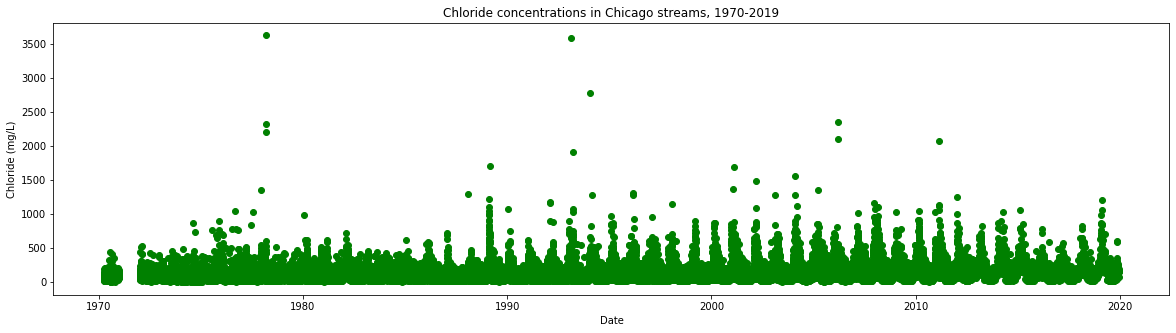

In [27]:
#This section creates a date plot of chloride data (across all stations) from 1970-2019,
#with a modified frame height/width and marker color, and x- and y-axis labels and a title. 
plt.rc('figure', figsize = (20, 5))
fig1, ax = plt.subplots()
ax.plot_date(singledf.matplotDate, singledf.Chloride, xdate = True, color='g')
ax.set_title('Chloride concentrations in Chicago streams, 1970-2019')
ax.set_xlabel('Date')
ax.set_ylabel('Chloride (mg/L)')

In [28]:
#next: subset singledf for each month.
#This section makes two new columns, year, and month, and fills them from the datetime so that
#data can be filtered by month or year.
#it also counts the number of successes (m) and failures (n, from try/except) of this operation.

m = 1
n = 1
singledf['year'] = pd.Series()
singledf['month'] = pd.Series()
for i in range(0, len(singledf)):
    try:
        singledf['year'][i] = singledf.Date[i].year
        m = m+1
        singledf['month'][i] = singledf.Date[i].month
    except KeyError as err:
        n = n+1

C:\Users\mmcke\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\mmcke\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':
C:\Users\mmcke\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\mmcke\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [29]:
m

27282

In [30]:
n

408

In [31]:
#this section creates a new dataframe for each month, containing only data from that month (over all ~50 years)
jan_df = singledf.loc[singledf['month'] == 1, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
feb_df = singledf.loc[singledf['month'] == 2, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
mar_df = singledf.loc[singledf['month'] == 3, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
apr_df = singledf.loc[singledf['month'] == 4, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
may_df = singledf.loc[singledf['month'] == 5, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
jun_df = singledf.loc[singledf['month'] == 6, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
jul_df = singledf.loc[singledf['month'] == 7, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
aug_df = singledf.loc[singledf['month'] == 8, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
sep_df = singledf.loc[singledf['month'] == 9, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
oct_df = singledf.loc[singledf['month'] == 10, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
nov_df = singledf.loc[singledf['month'] == 11, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]
dec_df = singledf.loc[singledf['month'] == 12, ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]

In [32]:
#this section creates a tuple, monthly_data, with the Chloride data for each month
#what if I force it to be a different structure?

monthly_data = jan_df['Chloride'], feb_df['Chloride'], mar_df['Chloride'], apr_df['Chloride'],\
may_df['Chloride'], jun_df['Chloride'], jul_df['Chloride'], aug_df['Chloride'], sep_df['Chloride'],\
oct_df['Chloride'], nov_df['Chloride'], dec_df['Chloride']

#list of lists: boxplot still works, violinplot still gives key error
#monthly_data = [jan_df['Chloride'], feb_df['Chloride'], mar_df['Chloride'], apr_df['Chloride'],\
#may_df['Chloride'], jun_df['Chloride'], jul_df['Chloride'], aug_df['Chloride'], sep_df['Chloride'],\
#oct_df['Chloride'], nov_df['Chloride'], dec_df['Chloride']]

#how to make each Series a column in a dataframe? not this way...
#monthly_data = pd.DataFrame([jan_df['Chloride']], [feb_df['Chloride']])
                            #, [mar_df['Chloride']],\
                            #[apr_df['Chloride']], [may_df['Chloride']] 
#[jun_df['Chloride']])
                            #[jul_df['Chloride']], [aug_df['Chloride']], [sep_df['Chloride']],\
                            #[oct_df['Chloride']], [nov_df['Chloride']], [dec_df['Chloride']])

{'whiskers': [<matplotlib.lines.Line2D at 0x211f8ac6ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x211f91cff48>,
 'boxes': [<matplotlib.lines.Line2D at 0x211faadc408>,
 'medians': [<matplotlib.lines.Line2D at 0x211f8ac7608>,
 'fliers': [],
 'means': []}

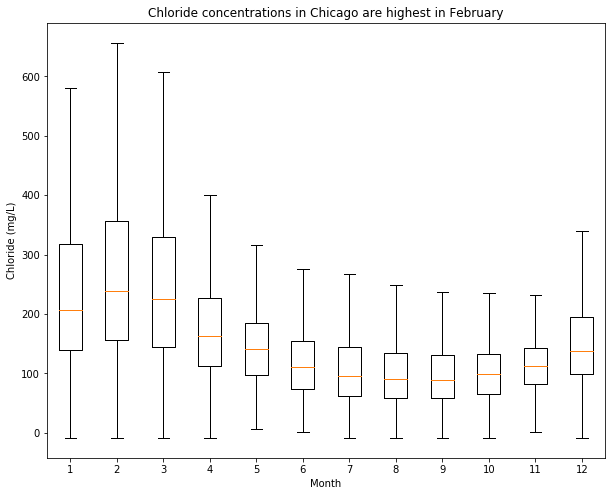

In [33]:
#this section creates a boxplot showing summary statistics for all years, by month, revealing a general trend
#of peak concentrations in Feb and March, and lower concentrations in summer and early fall months.

plt.rc('figure', figsize = (10, 8))
fig2, ax2 = plt.subplots()
ax2.set_title('Chloride concentrations in Chicago are highest in February')
ax2.set_xlabel('Month')
ax2.set_ylabel('Chloride (mg/L)')
ax2.boxplot(monthly_data, showfliers = False)

In [34]:
#this section creates a new dictionary of dataframes for each station
dictByStation = dict()
listOfStations = list(singledf.Station.unique())
for stationNumber in listOfStations:
    dictByStation[stationNumber] = singledf.loc[singledf['Station'] == stationNumber,\
                                 ['Date', 'Station', 'Chloride', 'matplotDate', 'year', 'month']]

In [35]:
#this records the number of years of data recorded at each station, matched to station,
#and sorts from least to most, which I'll use to determine the minimum years of data 
#to require for inclusion in figure 4.
stationObsYears = list()
for key in dictByStation:
    x = len(dictByStation[key].year.unique())
    y = key 
    stationObsYears.append((x,y))
stationObs_df = pd.Series(stationObsYears)
stationObs_df.sort_values()

101      (1, 10)
13       (1, 25)
14       (1, 26)
15       (1, 27)
16       (1, 28)
26       (1, 44)
27       (1, 45)
29       (1, 47)
47       (1, 60)
36       (1, 61)
53       (1, 67)
54       (1, 68)
55       (1, 69)
56       (1, 70)
57       (1, 71)
58       (1, 72)
100     (2, 107)
102     (2, 113)
2        (5, 14)
3        (5, 15)
4        (5, 16)
21       (5, 33)
34       (5, 38)
42       (5, 53)
51       (5, 65)
52       (5, 66)
72       (6, 82)
69       (6, 85)
81        (7, 1)
82        (7, 2)
78        (7, 3)
74        (7, 4)
75        (7, 5)
79        (7, 6)
77        (7, 7)
76        (7, 8)
80        (7, 9)
85      (8, 112)
90      (9, 111)
99       (9, 97)
97     (12, 101)
96     (12, 102)
95     (12, 103)
94     (12, 104)
93     (12, 105)
98     (12, 106)
63     (13, 8.4)
91      (15, 91)
92      (15, 96)
89     (16, 110)
86      (16, 92)
87      (16, 99)
88     (18, 109)
83     (19, 100)
84     (19, 108)
40      (19, 51)
49      (24, 63)
73      (24, 86)
71      (24, 8

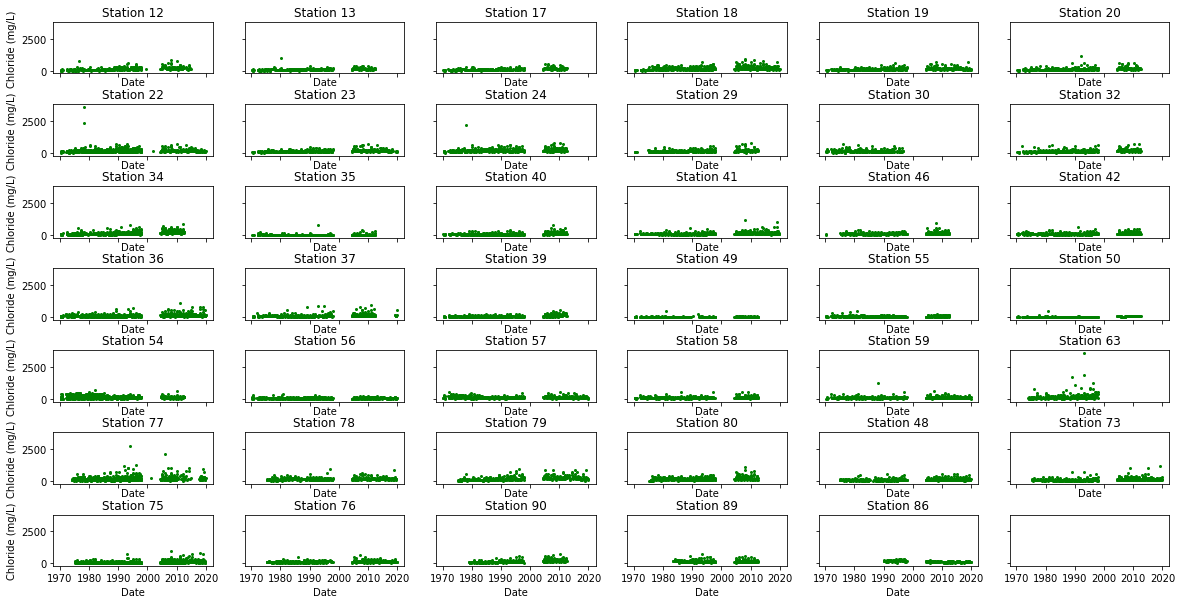

In [36]:
#creates a 7x6 array of plots, with each plot representing the chloride measurements at one station from 1970-2019
#limited to stations with at least 20 years of data
#plot array padding accomodates subplot title indicating station number
#marker size reduced for clarity

plt.rc('figure', figsize = (20, 10))
fig3, ax3 = plt.subplots(7, 6, sharex = True, sharey = True)
plt.subplots_adjust(hspace=0.6)
i = 0
j = 0
for key in dictByStation:
    if len(dictByStation[key].year.unique()) > 20:
        if i < 6:
            ax3[j][i].plot_date(dictByStation[key].matplotDate, dictByStation[key].Chloride, xdate = True,\
                                 color='g', ms=2)
            ax3[j][i].set_title('Station ' + key)
            ax3[j][i].set_xlabel('Date')
            if j ==0 and i ==0:
                ax3[j][i].set_ylabel('Chloride (mg/L)')
            i = i + 1
        else: 
            i = 0
            j = j + 1
            ax3[j][i].plot_date(dictByStation[key].matplotDate, dictByStation[key].Chloride, xdate = True,\
                                 color='g', ms=2)
            ax3[j][i].set_title('Station ' + key)
            ax3[j][i].set_xlabel('Date')
            ax3[j][i].set_ylabel('Chloride (mg/L)')